In [1]:
import pandas as pd
train_bench=pd.read_csv("train_bench.tsv", sep="\t")
train_bench
print("Number of OrganismName unique values: ",train_bench["OrganismName"].nunique())


Number of OrganismName unique values:  435


In [2]:
#Recover the ten most frequent OrganismName to make the unique value number of OrganismName field comparable to Kingdom field unique value number
tmp_var=train_bench.groupby('OrganismName').nunique().sort_values(by='EntryID', ascending=False).head(6).reset_index()
tmp_most_rep=tmp_var['OrganismName'].tolist()
train_bench.loc[~train_bench["OrganismName"].isin(tmp_most_rep), "OrganismName"] = "Other"
print("Number of OrganismName unique values: ",train_bench["OrganismName"].nunique())

Number of OrganismName unique values:  7


## Pie Plot and Bar Plots of Taxonomic classification

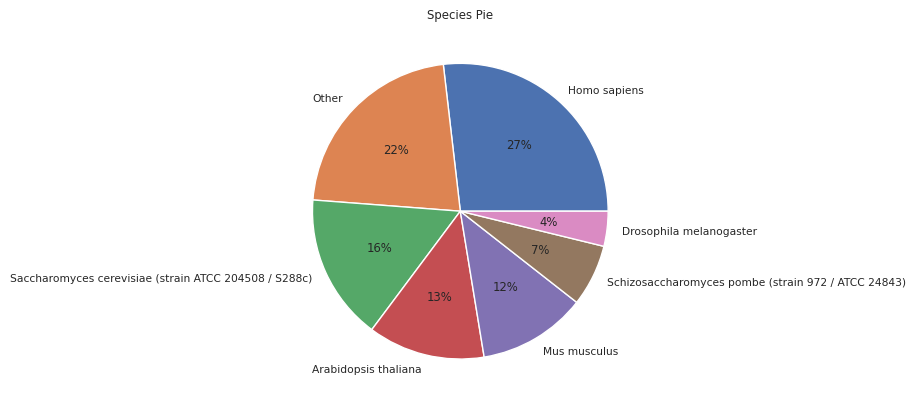

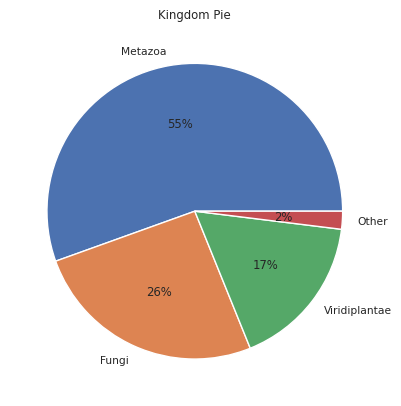

Text(0.5, 0.98, 'Kingdom Barplot')

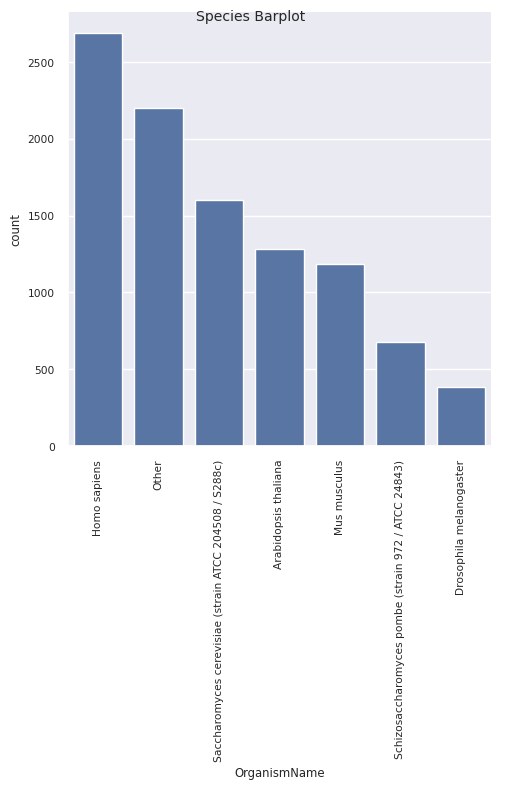

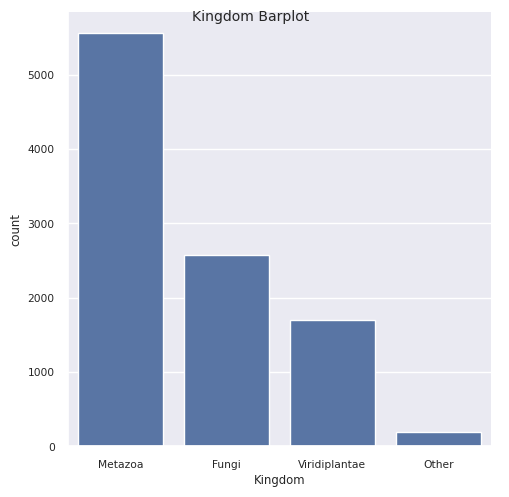

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
#Create the pie plot with respect of OrganismName
sns.set_theme(context='notebook', style='darkgrid', palette='deep',font='sans-serif', font_scale=0.7,color_codes=True,rc=None)
counts_organismname=train_bench['OrganismName'].value_counts()
plt.pie(counts_organismname, labels=counts_organismname.index,autopct='%1.0f%%')
plt.title("Species Pie")
plt.show()

#Create the pie plot with respect of Kingdom
counts_kingdom=train_bench['Kingdom'].value_counts()
plt.pie(counts_kingdom, labels=counts_kingdom.index,autopct='%1.0f%%')
plt.title("Kingdom Pie")
plt.show()

#Create the barplot with respect of OrganismName
counts_organismname=counts_organismname.to_frame(name="count")
sns.catplot(counts_organismname, x="OrganismName",y="count", kind='bar').set_xticklabels(rotation=90).fig.suptitle("Species Barplot")   


#Create the barplot with respect of Kingdom
counts_kingdom=counts_kingdom.to_frame(name="count")
sns.catplot(counts_kingdom, x="Kingdom",y="count", kind='bar').fig.suptitle("Kingdom Barplot")

## Cleavage fasta file with cleavage site Motifs for WebLogo

In [12]:
#We need to convert it in the fasta file
train_bench_pos=train_bench.query('Class=="Positive"')
train_bench_pos
#you have to recover -12 from SPend and +3 after SPend
with open("seqlogo.fasta" , 'w') as file1:
    for index,row in train_bench_pos.iterrows():
        sequence_to_recover=row["Sequence"]
        cleavage_position=int(row["SPEnd"])
        print(">"+row["EntryID"].strip()+"\n"+sequence_to_recover[cleavage_position-13:cleavage_position+3],file=file1)

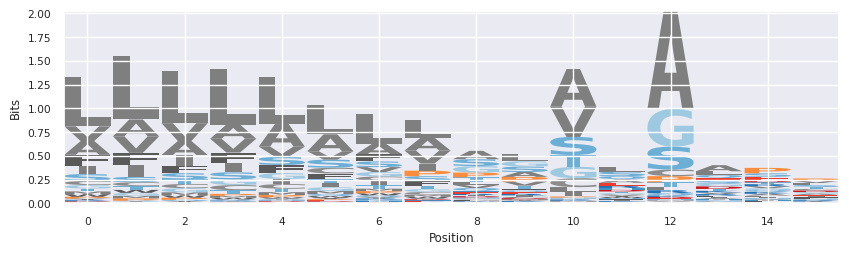

In [17]:
from Bio import SeqIO
import logomaker as lm

fasta_path = "seqlogo.fasta"

# 1. Leggi le sequenze
records = list(SeqIO.parse(fasta_path, "fasta"))
if not records:
    raise ValueError(f"Nessuna sequenza trovata in {fasta_path}")

seqs = [str(r.seq).upper() for r in records]

# 2. Controllo lunghezze
L = len(seqs[0])
if any(len(s) != L for s in seqs):
    raise ValueError("Le sequenze devono avere TUTTE la stessa lunghezza.")

# 3. Costruisci matrice conteggi (posizioni × caratteri)
alphabet = sorted({c for s in seqs for c in s})
counts = pd.DataFrame(0, index=range(L), columns=alphabet)
for s in seqs:
    for i, c in enumerate(s):
        counts.loc[i, c] += 1

# 4. Frequenze (PPM)
ppm = counts.div(counts.sum(axis=1), axis=0).fillna(0)

# 5. Information content per colonna (proteine: log2(20))
eps = 1e-12
entropy = -(ppm * np.log2(ppm + eps)).sum(axis=1)
Rseq = np.log2(len(ppm.columns)) - entropy  # in bit

# 6. Matrice heights = frequenze × information content
ic_mat = ppm.mul(Rseq, axis=0)

# 7. Dizionario colori personalizzato (gruppi chimici)
color_dict = {
    'A':'#7f7f7f','V':'#7f7f7f','I':'#7f7f7f','L':'#7f7f7f','M':'#7f7f7f',
    'F':'#595959','W':'#595959','Y':'#595959','C':'#8c8c8c',
    'S':'#6baed6','T':'#6baed6','N':'#6baed6','Q':'#6baed6','G':'#9ecae1',
    'K':'#2171b5','R':'#2171b5','H':'#4292c6',
    'D':'#cb181d','E':'#ef3b2c',
    'P':'#fd8d3c'
}

# 8. Mappatura colori completa (nero per simboli non previsti)
all_colors = {c: color_dict.get(c, 'black') for c in ic_mat.columns}

# 9. Disegna il logo
ax = lm.Logo(ic_mat, color_scheme=all_colors)
ax.ax.set_xlabel("Position")
ax.ax.set_ylabel("Bits")
plt.show()
